# Проект: классификация

**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.<br><br>

**Техническая задача для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

**Данные о клиентах банка:**

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).<br><br>

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).<br><br>

**Прочие признаки:**

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).<br><br>

**Целевая переменная deposit,** которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import GridSearchCV
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1 Пропущенные значения

In [3]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?

df.info()
df.isnull().sum()

# Признак, где пропущенных значений больше всего: balance (25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2 Скрытые пропуски

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?

df.value_counts()

# Слово, которым закодированы пропуски (неизвестные значения): unknown

age  job         marital   education  default  balance        housing  loan  contact    day  month  duration  campaign  pdays  previous  poutcome  deposit
18   student     single    primary    no        608,00 $      no       no    cellular   12   aug    267       1         -1     0         unknown   yes        1
45   management  single    tertiary   no        4 831,00 $    no       no    cellular   30   jul    852       3          182   11        success   yes        1
                 married   tertiary   yes      -577,00 $      yes      yes   cellular   24   jul    204       1         -1     0         unknown   no         1
                           unknown    no        2 724,00 $    no       no    cellular   28   jun    359       2          182   1         success   yes        1
                                                9 051,00 $    yes      no    unknown    19   may    124       63        -1     0         unknown   no         1
                                             

### Задание 3 Обработка пропусков

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(',', '.')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].astype(float)
round(df['balance'].mean(), 3) # среднее значение баланса

# Среднее значение по преобразованному в корректный вид признаку balance: 1529.129

1529.129

In [7]:
# альтернативные вариант
#df = pd.read_csv('bank_fin.csv', sep = ';')
#def make_convert(row):
#    row = str(row)
#    if row != 'unknown':
#        row = row.replace(',00', '')
#        row = row.replace('$', '')
#        row = row.replace(' ', '')
#        return float(row)
#    else:
#        return np.nan

### Задание 4 Обработка пропусков

In [8]:
# обработайте пропуски в признаке balance , заменив их на медианные значения по данному признаку

df['balance'] = df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(), 3) # среднее значение баланса после замены пропусков

# Среднее значение по преобразованному в корректный вид признаку balance: 1526.936

1526.936

### Задание 5 Обработка пропусков

In [9]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['education'] = df['education'].replace('unknown', df['education'].mode()[0])

round(df.loc[((df['job']=='management') & (df['education']=='secondary'))]['balance'].mean(), 3) # среднее значение баланса для тех клиентов,
# у которых модальное значение в столбцах job и education

# Средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования: 1598.883

1598.883

### Задание 6 Удаление выбросов

In [10]:
# удалите все выбросы для признака balance

# функция для нахождения выбросов методом Тьюки
def find_outliers_iqr(data, feature, left=1.5, right=1.5, log_scale=False): 
    """
    Находит выбросы в данных, используя метод межквартильного размаха. 
    Классический метод модифицирован путем добавления:
    * возможности логарифмирования распредления
    * ручного управления количеством межквартильных размахов в обе стороны распределения
    Args:
        data (pandas.DataFrame): набор данных
        feature (str): имя признака, на основе которого происходит поиск выбросов
        left (float, optional): количество межквартильных размахов в левую сторону распределения. По умолчанию 1.5.
        right (float, optional): количество межквартильных размахов в правую сторону распределения. По умолчанию 1.5.
        log_scale (bool, optional): режим логарифмирования. По умолчанию False - логарифмирование не применяется.

    Returns:
        pandas.DataFrame: наблюдения, попавшие в разряд выбросов
        pandas.DataFrame: очищенные данные, из которых исключены выбросы
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return cleaned, outliers, lower_bound, upper_bound

cleaned, outliers, lower_bound, upper_bound = find_outliers_iqr(df, 'balance', left=1.5, right=1.5, log_scale=False)

print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Верхняя граница: {lower_bound}')
print(f'Нижняя граница: {upper_bound}')

df_cleaned = df.drop(outliers.index, axis=0)
print(f'Результирующее число записей: {df_cleaned.shape[0]}')

Результирующее число записей: 10105
Верхняя граница: -2241.0
Нижняя граница: 4063.0
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1 Изучение целевой переменной

no     5424
yes    4681
Name: deposit, dtype: int64

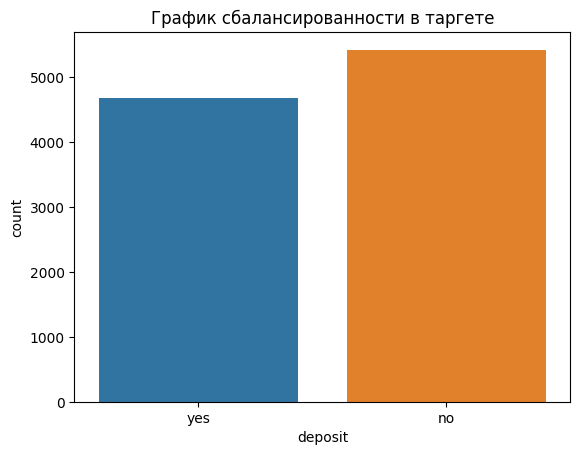

In [11]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

sns.countplot(data=df_cleaned, x='deposit').set_title('График сбалансированности в таргете');
df_cleaned['deposit'].value_counts()

# Открыли депозит 4681 клиентов

### Задания 2 и 3 Изучение количественных признаков

In [12]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

df_cleaned.describe()

# Максимальный возраст клиента банка 95 лет
# Минимальная продолжительность разговора с клиентом банка 2 сек.

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


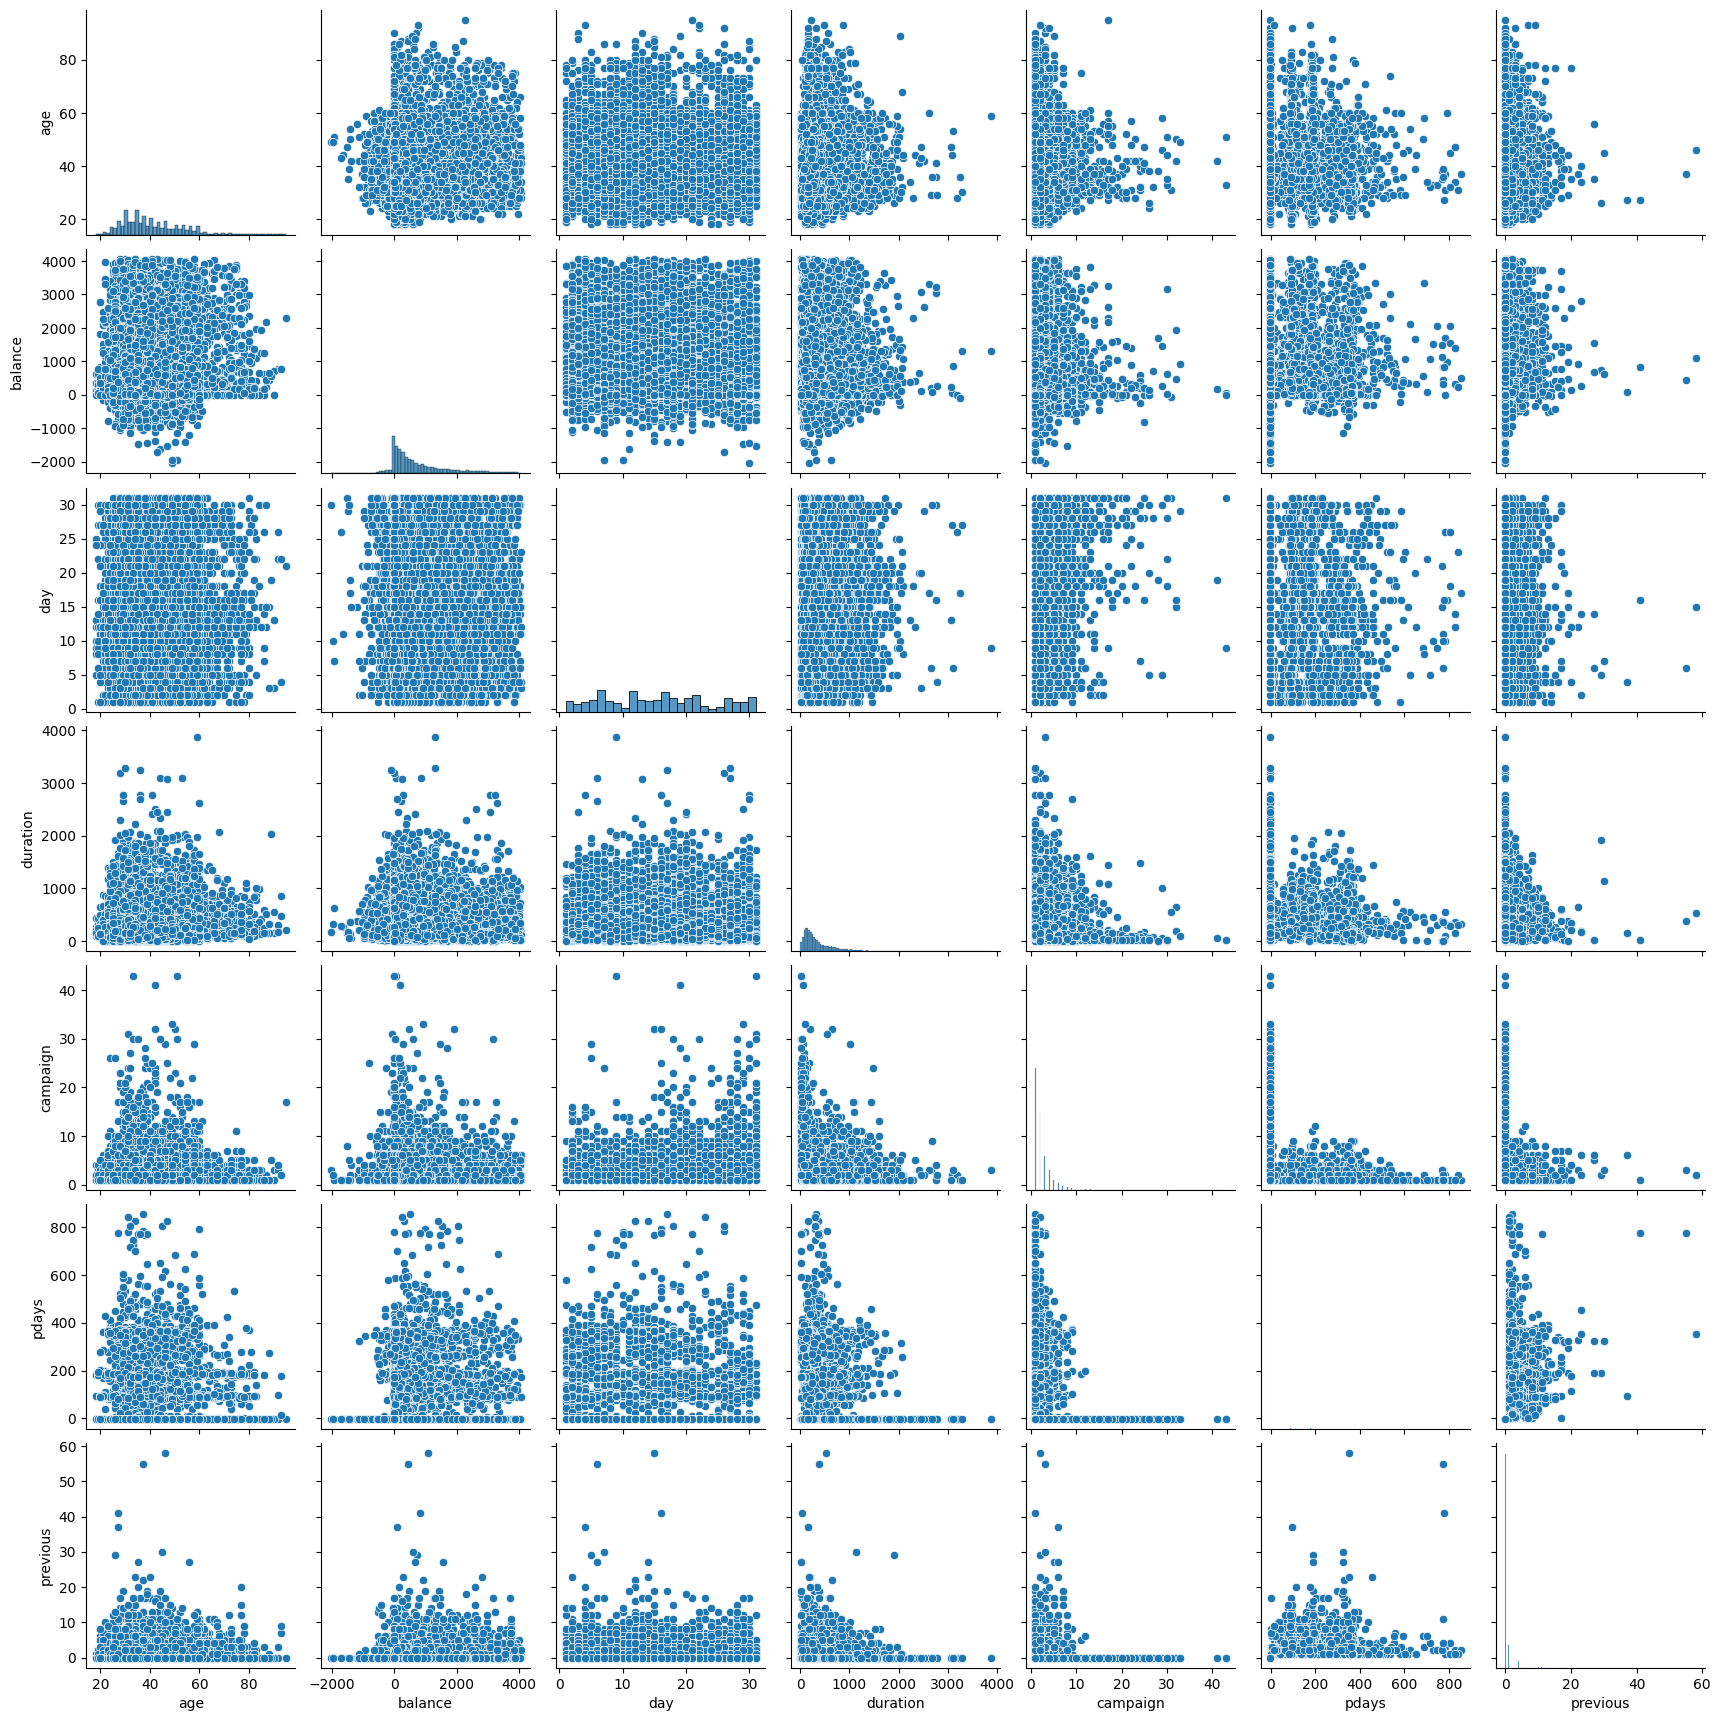

In [13]:
# исследование числовых данных

sns.pairplot(df_cleaned)

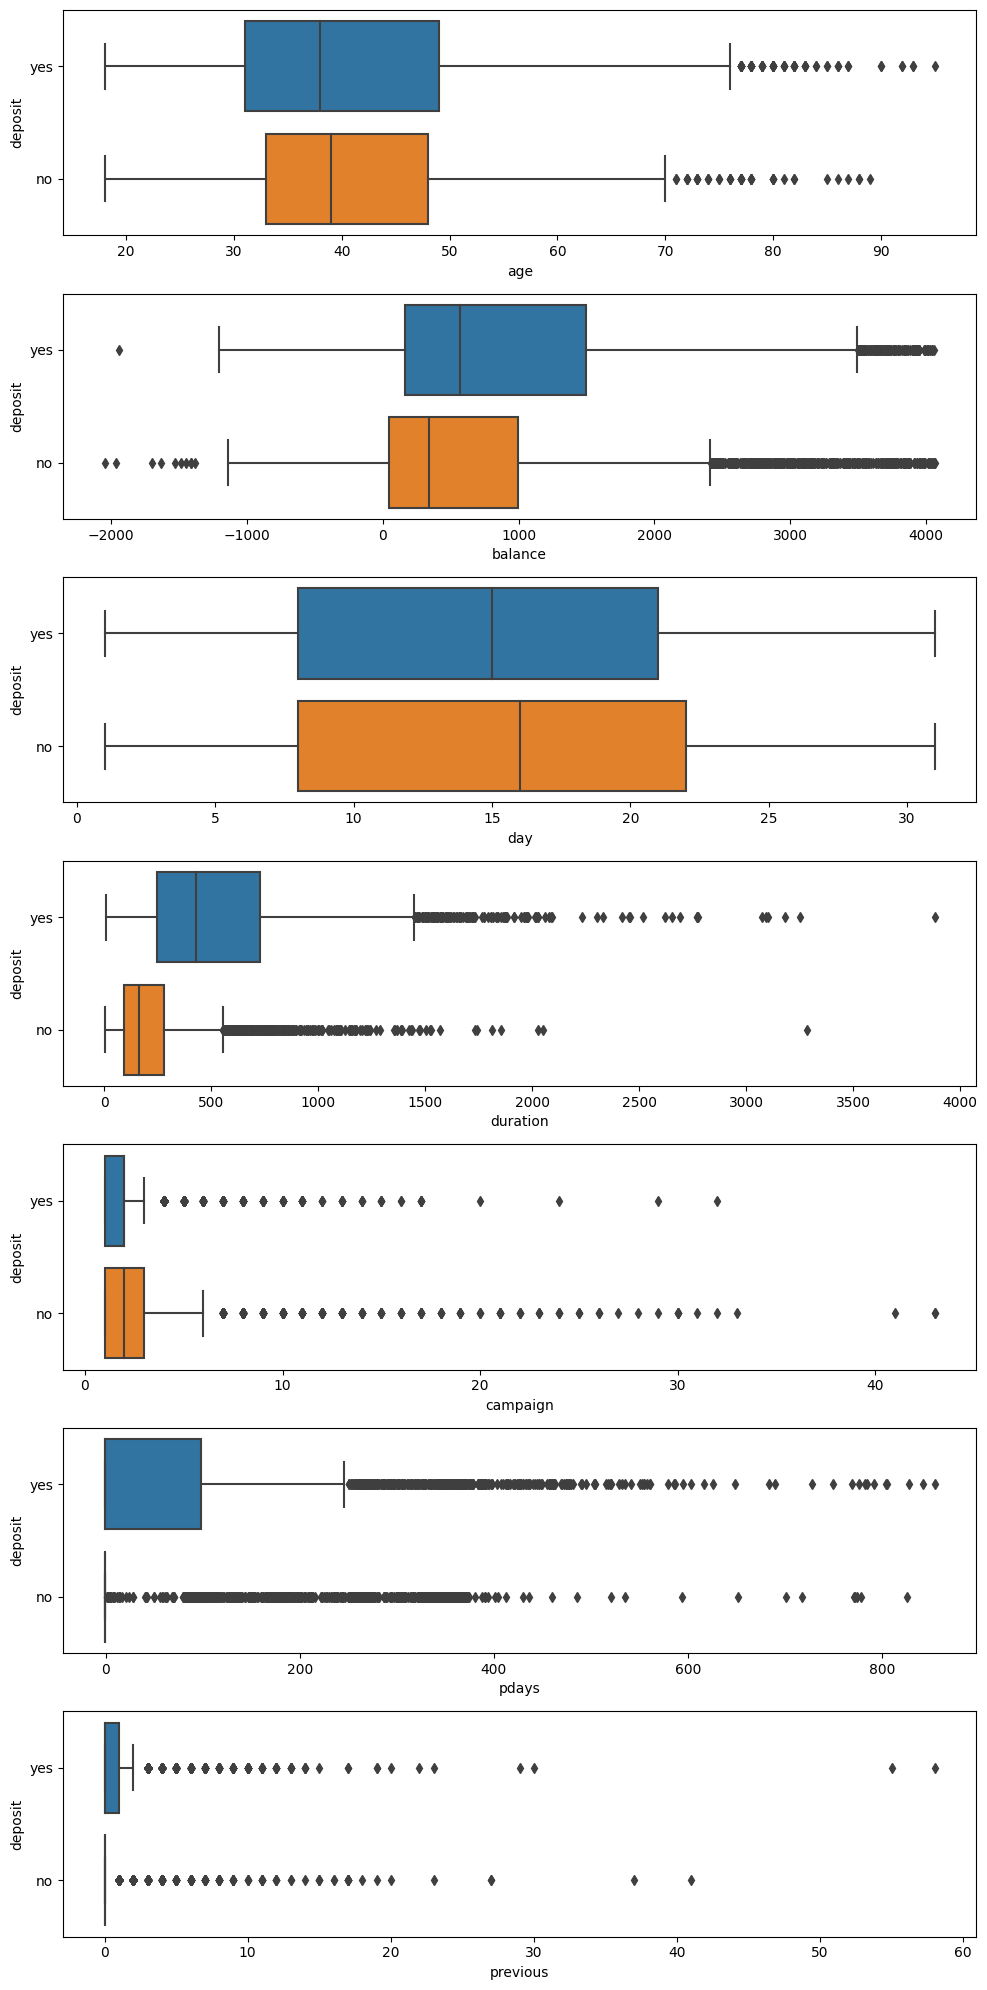

In [14]:
types = df_cleaned.dtypes
features = list(types[(types != 'object')].index)
n = len(features)
fig, axes = plt.subplots(n, figsize=(10, 20))
for i, feature in enumerate(features):
    sns.boxplot(data=df_cleaned, x=feature, y='deposit', ax=axes[i])
plt.tight_layout()

**Выводы по исследованию числовых признаков:**

Были построены графики, показывающие распределение по каждому признаку попарно и диаграммы размаха в разрезе целевого признака deposit.<br><br>

Можно сделать следующие выводы по клиентам, склонным открыть депозит в банке:
1. По признаку возраст (age) - средний возраст большинства клиентов, с которыми был достигнут положительный результат в кампании, 38 лет. (Совпадает с отрицательным результатом). При это на графике видно, что после 90 лет присутствуют выбросы. Большинство клиентов, согласившихся на депозит от 30 до 48 лет.<br>

2. По признаку баланс (balance) - логнормальное распределение. Среднее значение баланса у клиентов, с которыми был достигнут положительный результат в кампании, 500 долл. Так же чем больше баланс у клиента, тем более возможно положительное решение в сторону депозита. Чем старше клиент, тем меньше возможность отрицательного баланса. Максимальное количество клиентов с положительным решением с балансом от 100 до 1500 долларов. Так же присутствуют выбросы после 4000 долл.<br>

3. Продолжительность контакта (duration) - логнормальное распределение. Видно, что чем больше продолжительность контакта с клиентом, тем больше возможность его согласия на депозит в банке. Средняя продолжительность контакта для таких клиентов 6,6 минут. Большинство клиентов, согласившихся на депозит, общались от 5 до 12 минут. Так же присутствуют выбросы после 30-35 минут разговора.<br>

4. Количество контактов (campaign) - логнормальное распределение. Видно, что чем больше контактов, тем меньше возможность согласия клиента на депозит.
Среднее количество контактов для "положительных" клиентов 2, это же максимальное число для них. Можно предположить, что после 18 контактов присутствуют выбросы.<br>

5. Для признаков pdays и previous  - так же присутствуют выбросы.

**Для данных признаков в дальнейшем для подачи в модель следует перевести часть признаков в логарифмическое распределение и избавиться от выбросов с помощью метода Тьюки или метода z-отклонений.**

### Задания 4 и 5 Изучение категориальных признаков

In [15]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#постройте визуализации, иллюстрирующие результаты

df_cleaned.describe(include = 'object')

# Маркетинговая кампания проводилась в 12 мес.
# Представлено 11 сфер деятельности среди клиентов банка.

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


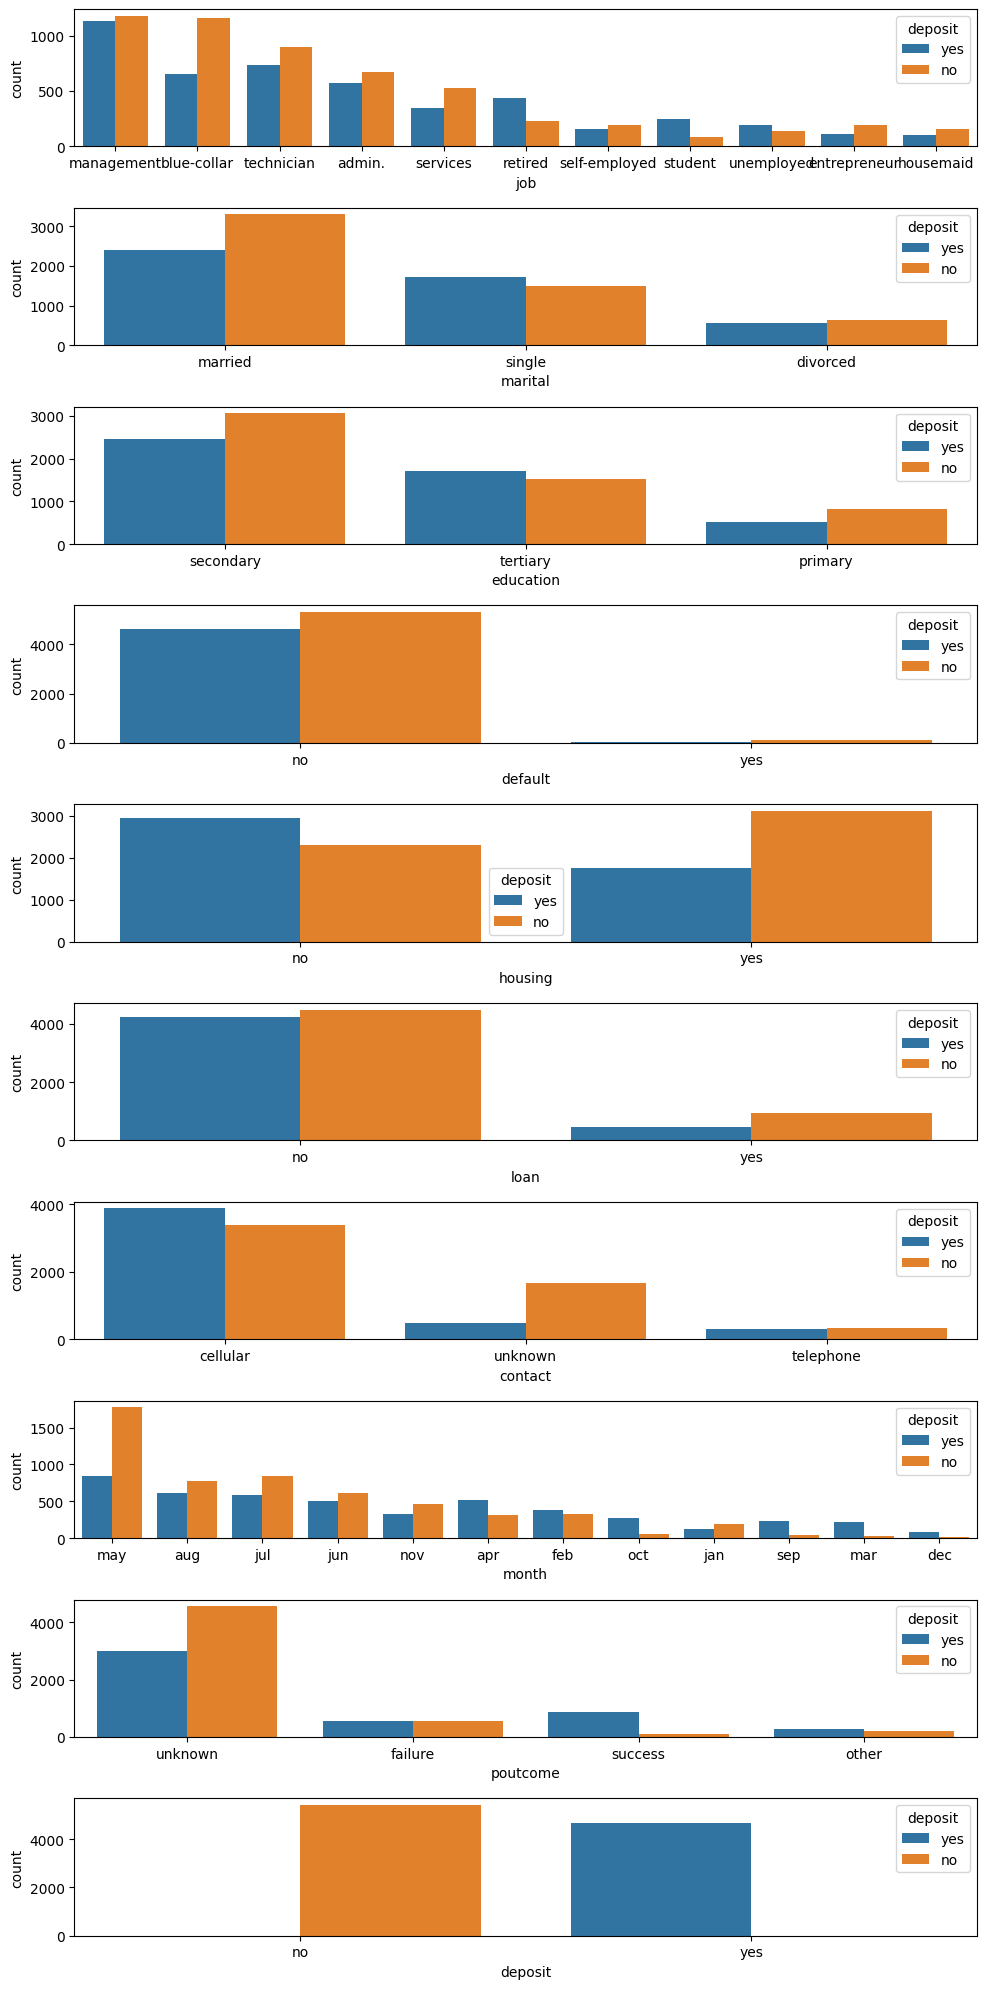

In [16]:
# исследование категориальных данных
types = df_cleaned.dtypes
cat_features = list(types[(types == 'object')].index)
n = len(cat_features)
fig, axes = plt.subplots(n, figsize=(10, 20))
for i, feature in enumerate(cat_features):
    sns.countplot(data=df_cleaned, x=feature, hue='deposit', order=df[feature].value_counts().index, ax=axes[i])
plt.tight_layout()

**Выводы по исследованию категориальных признаков:**

Были построены графики, показывающие распределение по каждому признаку в разрезе целевого признака deposit.<br><br>

Можно увидеть следующие закономерности для клиентов, которые будут склонны согласиться на депозит в банке:
1. Клиенты, с которыми была проведена успешно последняя маркетинговая кампания, склонны к положительному решению в будущей кампании.
2. Наиболее успешные звонки на сотовый телефон клиента (тип контакта - сотовый).
3. Так же наиболее склонны к открытию депозита клиенты без ипотечного кредита и без кредита на личные нужды.<br><br>

Далее данные, на которые так же стоит обратить внимание:
1. Одинокие клиенты чаще склонны согласиться на депозит в банке, но так как женатых\замужних клиентов больше в 1,5 раза, то не стоит их исключать.
2. Та же ситуация с образованием, по графику видно, что клиенты с высшим образование склонны к депозиту больше, но клиентов со средним образованием существенно больше.
3. Наиболее успешные месяцы кампании (большее количество клиентов, согласившихся на депозит, чем не согласившихся) это апрель, февраль, октябрь, сентябрь, март и декабрь, при этом максимальные продажи летом (май, июнь, июль, август).<br><br>

Соответственно, наиболее неудачные попытки с клиентами: с ипотекой, с потребительским кредитом и "синие воротнички".<br><br>

**Данные признаки в дальнейшем для подачи в модель следует преобразовать в числовые данные (default, housing, loan), остальные закодировать.**

### Задание 6 Изучение данных

In [17]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

df_cleaned_poutcome = df_cleaned.groupby('poutcome')['deposit'].value_counts().unstack().sort_values('yes', ascending=False)
df_cleaned_poutcome

# Значение статуса предыдущей кампании, для которой в текущей успехов намного больше, чем неудач: success	

deposit,no,yes
poutcome,,
unknown,4562,3008
success,84,861
failure,562,547
other,216,265


### Задание 7 Изучение данных

In [18]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

df_month = df_cleaned.groupby('month')['deposit'].value_counts().unstack().sort_values('no', ascending=False) 
df_month

# Cамый большой процент неудач в МАЕ

deposit,no,yes
month,,
may,1776,841
jul,836,582
aug,775,610
jun,606,498
nov,456,324
feb,323,386
apr,317,513
jan,194,125
oct,62,273


### Задание 8 Изучение данных

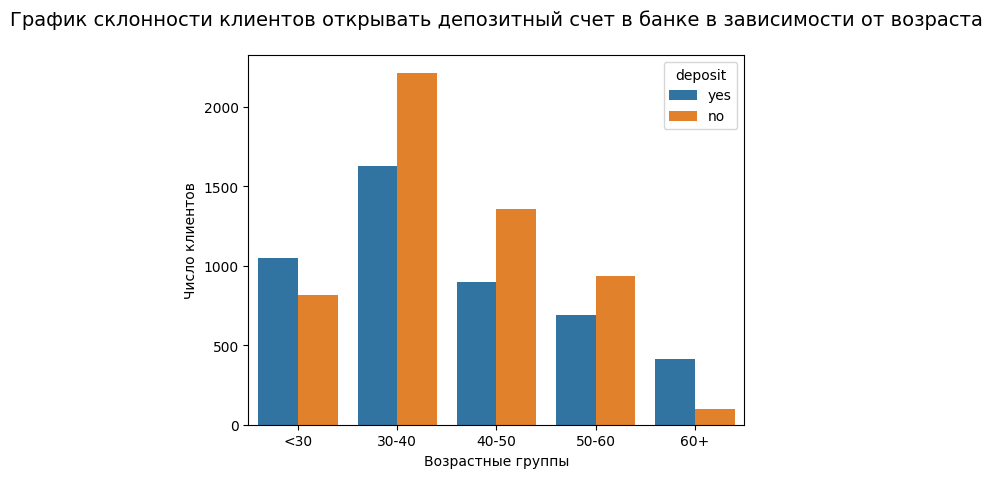

In [19]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

cut_labels_5 = ['<30', '30-40', '40-50', '50-60', '60+']
cut_bins = [0, 30, 40, 50, 60, 150]

df_cleaned['age_new'] = pd.cut(df_cleaned['age'],
                       bins=cut_bins,
                       labels=cut_labels_5)

ax = sns.countplot(x="age_new", hue="deposit", data=df_cleaned)
ax.set(xlabel='Возрастные группы', ylabel='Число клиентов')
ax.set_title('График склонности клиентов открывать депозитный счет в банке в зависимости от возраста\n', fontsize=14);

# Более склонны открывать депозит, чем отказываться от открытия депозита
# в банке после рекламного предложения клиенты в возрасте Б30 и 60+ лет.

### Задания 9 и 10 Изучение данных

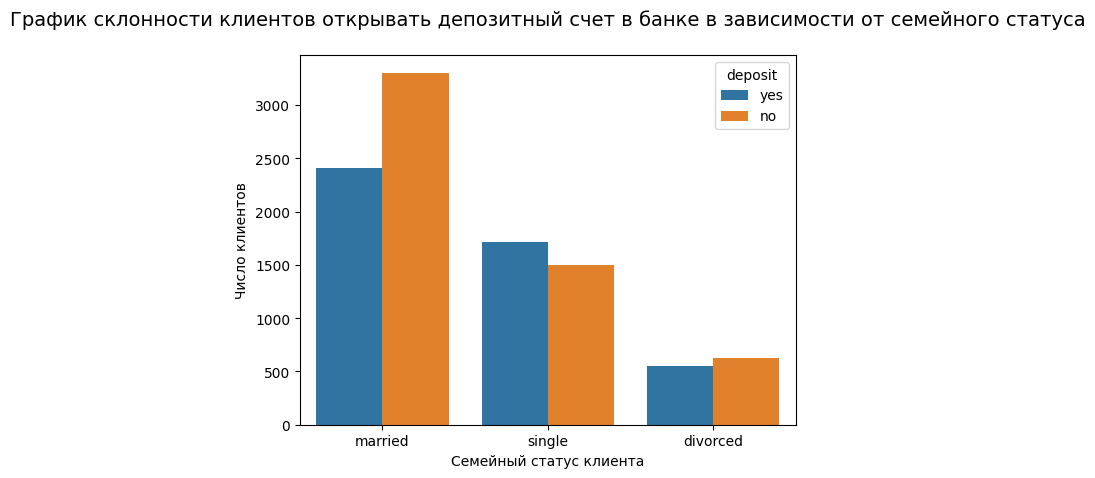

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

ax = sns.countplot(x="marital", hue="deposit", data=df_cleaned)
ax.set(xlabel='Семейный статус клиента', ylabel='Число клиентов')
ax.set_title('График склонности клиентов открывать депозитный счет в банке в зависимости от семейного статуса\n', fontsize=14);

# Семейное положение, при котором есть тенденция открывать депозит, а не отказываться от его открытия: single (одинокий)

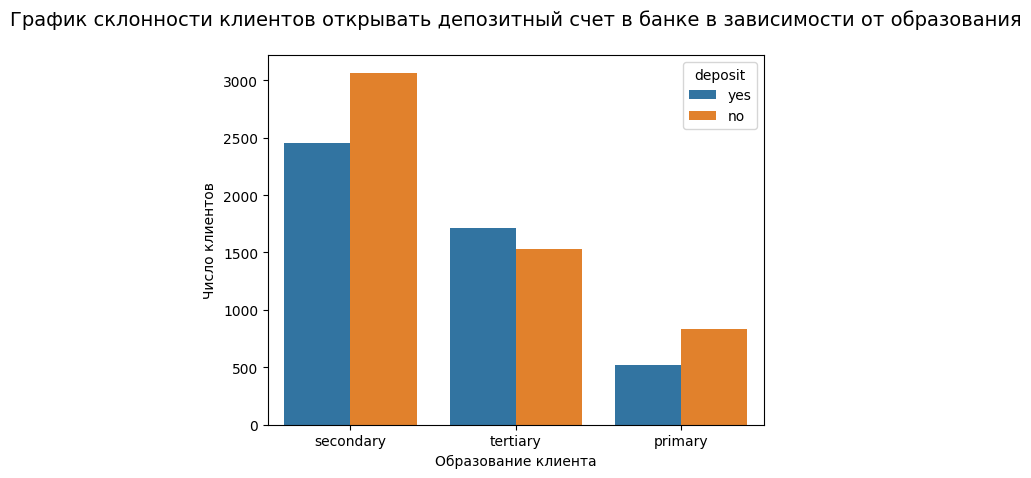

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

ax = sns.countplot(x="education", hue="deposit", data=df_cleaned)
ax.set(xlabel='Образование клиента', ylabel='Число клиентов')
ax.set_title('График склонности клиентов открывать депозитный счет в банке в зависимости от образования\n', fontsize=14);

# Образование, при котором есть тенденция открывать депозит, а не отказываться от его открытия: tertiary (высшее)

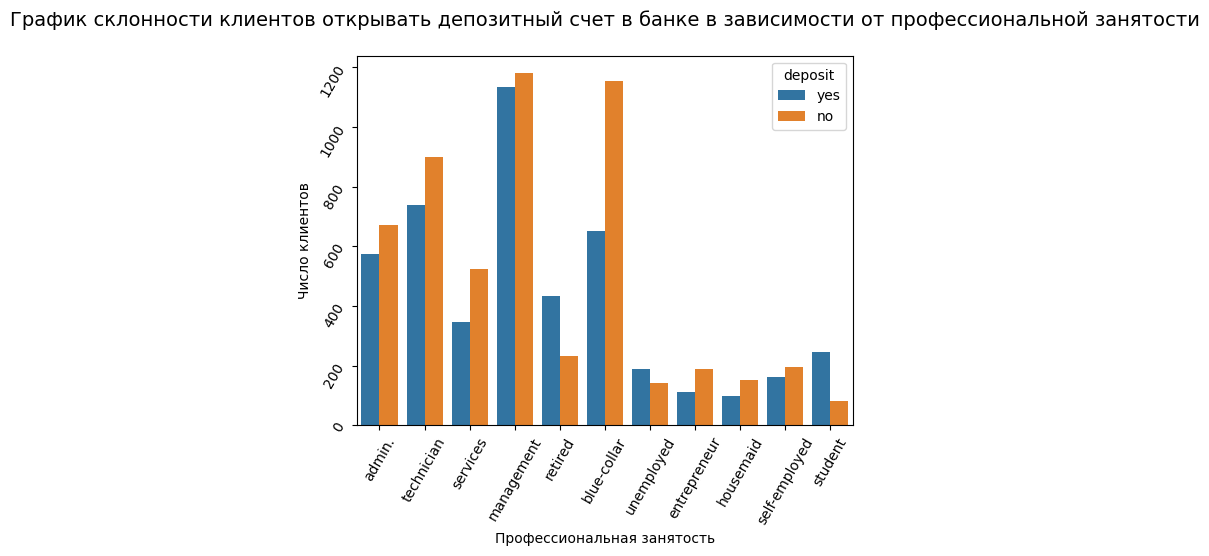

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

ax = sns.countplot(x="job", hue="deposit", data=df_cleaned)
ax.set(xlabel='Профессиональная занятость', ylabel='Число клиентов')
ax.set_title('График склонности клиентов открывать депозитный счет в банке в зависимости от профессиональной занятости\n', fontsize=14)
ax.tick_params(labelrotation=60);

# Профессиональна занятость, при которой есть тенденция открывать депозит, а не отказываться от его открытия: management (менеджмент)

### Задание 11 Изучение данных

[Text(0.5, 14.722222222222216, 'Семейный статус'),
 Text(518.4494949494949, 0.5, 'Образование')]

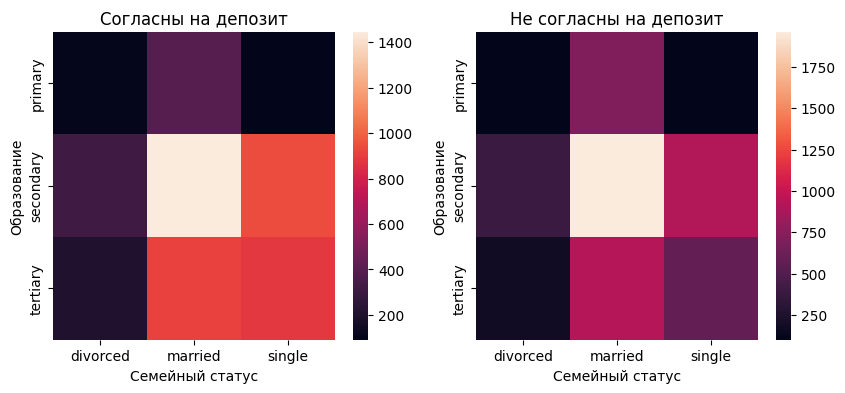

In [23]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

df_deposit_yes = df[df['deposit']=='yes']
df_deposit_no = df[df['deposit']=='no']

pivot_yes = pd.pivot_table(df_deposit_yes, index='education', columns='marital', values='age', aggfunc='count')  
pivot_no = pd.pivot_table(df_deposit_no, index='education', columns='marital', values='age', aggfunc='count')

fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(pivot_yes, ax=ax[0])
sns.heatmap(pivot_no, ax=ax[1])
ax[0].set_title('Согласны на депозит')
ax[1].set_title('Не согласны на депозит')
ax[0].set(xlabel='Семейный статус', ylabel='Образование')
ax[1].set(xlabel='Семейный статус', ylabel='Образование')


**Самые многочисленные категории клиентов среди открывших и неоткрывших депозит в банке: семейные (married) со средним образованием (secondary).**

## Часть 3: преобразование данных

### Задание 1 Кодирование признаков

In [24]:
# преобразуйте уровни образования

encoder = preprocessing.LabelEncoder()
df_cleaned['education'] = encoder.fit_transform(df_cleaned['education'])
df_cleaned['age_new'] = encoder.fit_transform(df_cleaned['age_new'])
df_cleaned['education'].sum()

11995

### Задания 2 и 3 Кодирование признаков

In [25]:
# преобразуйте бинарные переменные в представление из нулей и единиц

df_cleaned['deposit'] = df_cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleaned['deposit'].value_counts()
round(df_cleaned['deposit'].std(), 3)

# Стандартное отклонение по преобразованной в корректный вид целевой переменной deposit: 0,499

0.499

In [26]:
df_cleaned['default'] = df_cleaned['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleaned['housing'] = df_cleaned['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleaned['loan'] = df_cleaned['loan'].apply(lambda x: 1 if x == 'yes' else 0)

round(df_cleaned['default'].mean() + df_cleaned['housing'].mean() + df_cleaned['loan'].mean(), 3)

# Cреднее арифметическое для каждой из получившихся переменных, сложить три результата: 0.635

0.635

### Задание 4 Кодирование признаков

In [27]:
# создайте дамми-переменные

dummies = pd.get_dummies(df_cleaned[['job', 'marital', 'contact', 'month', 'poutcome']])
df = pd.concat([df_cleaned, dummies], axis=1)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   job                10105 non-null  object 
 2   marital            10105 non-null  object 
 3   education          10105 non-null  int32  
 4   default            10105 non-null  int64  
 5   balance            10105 non-null  float64
 6   housing            10105 non-null  int64  
 7   loan               10105 non-null  int64  
 8   contact            10105 non-null  object 
 9   day                10105 non-null  int64  
 10  month              10105 non-null  object 
 11  duration           10105 non-null  int64  
 12  campaign           10105 non-null  int64  
 13  pdays              10105 non-null  int64  
 14  previous           10105 non-null  int64  
 15  poutcome           10105 non-null  object 
 16  deposit            101

In [29]:
# удаляем преобразованные столбцы типа object

obj_columns = df.select_dtypes('object').columns
df.drop(columns=obj_columns, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_new            10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6 Оценка мультиколлинеарности

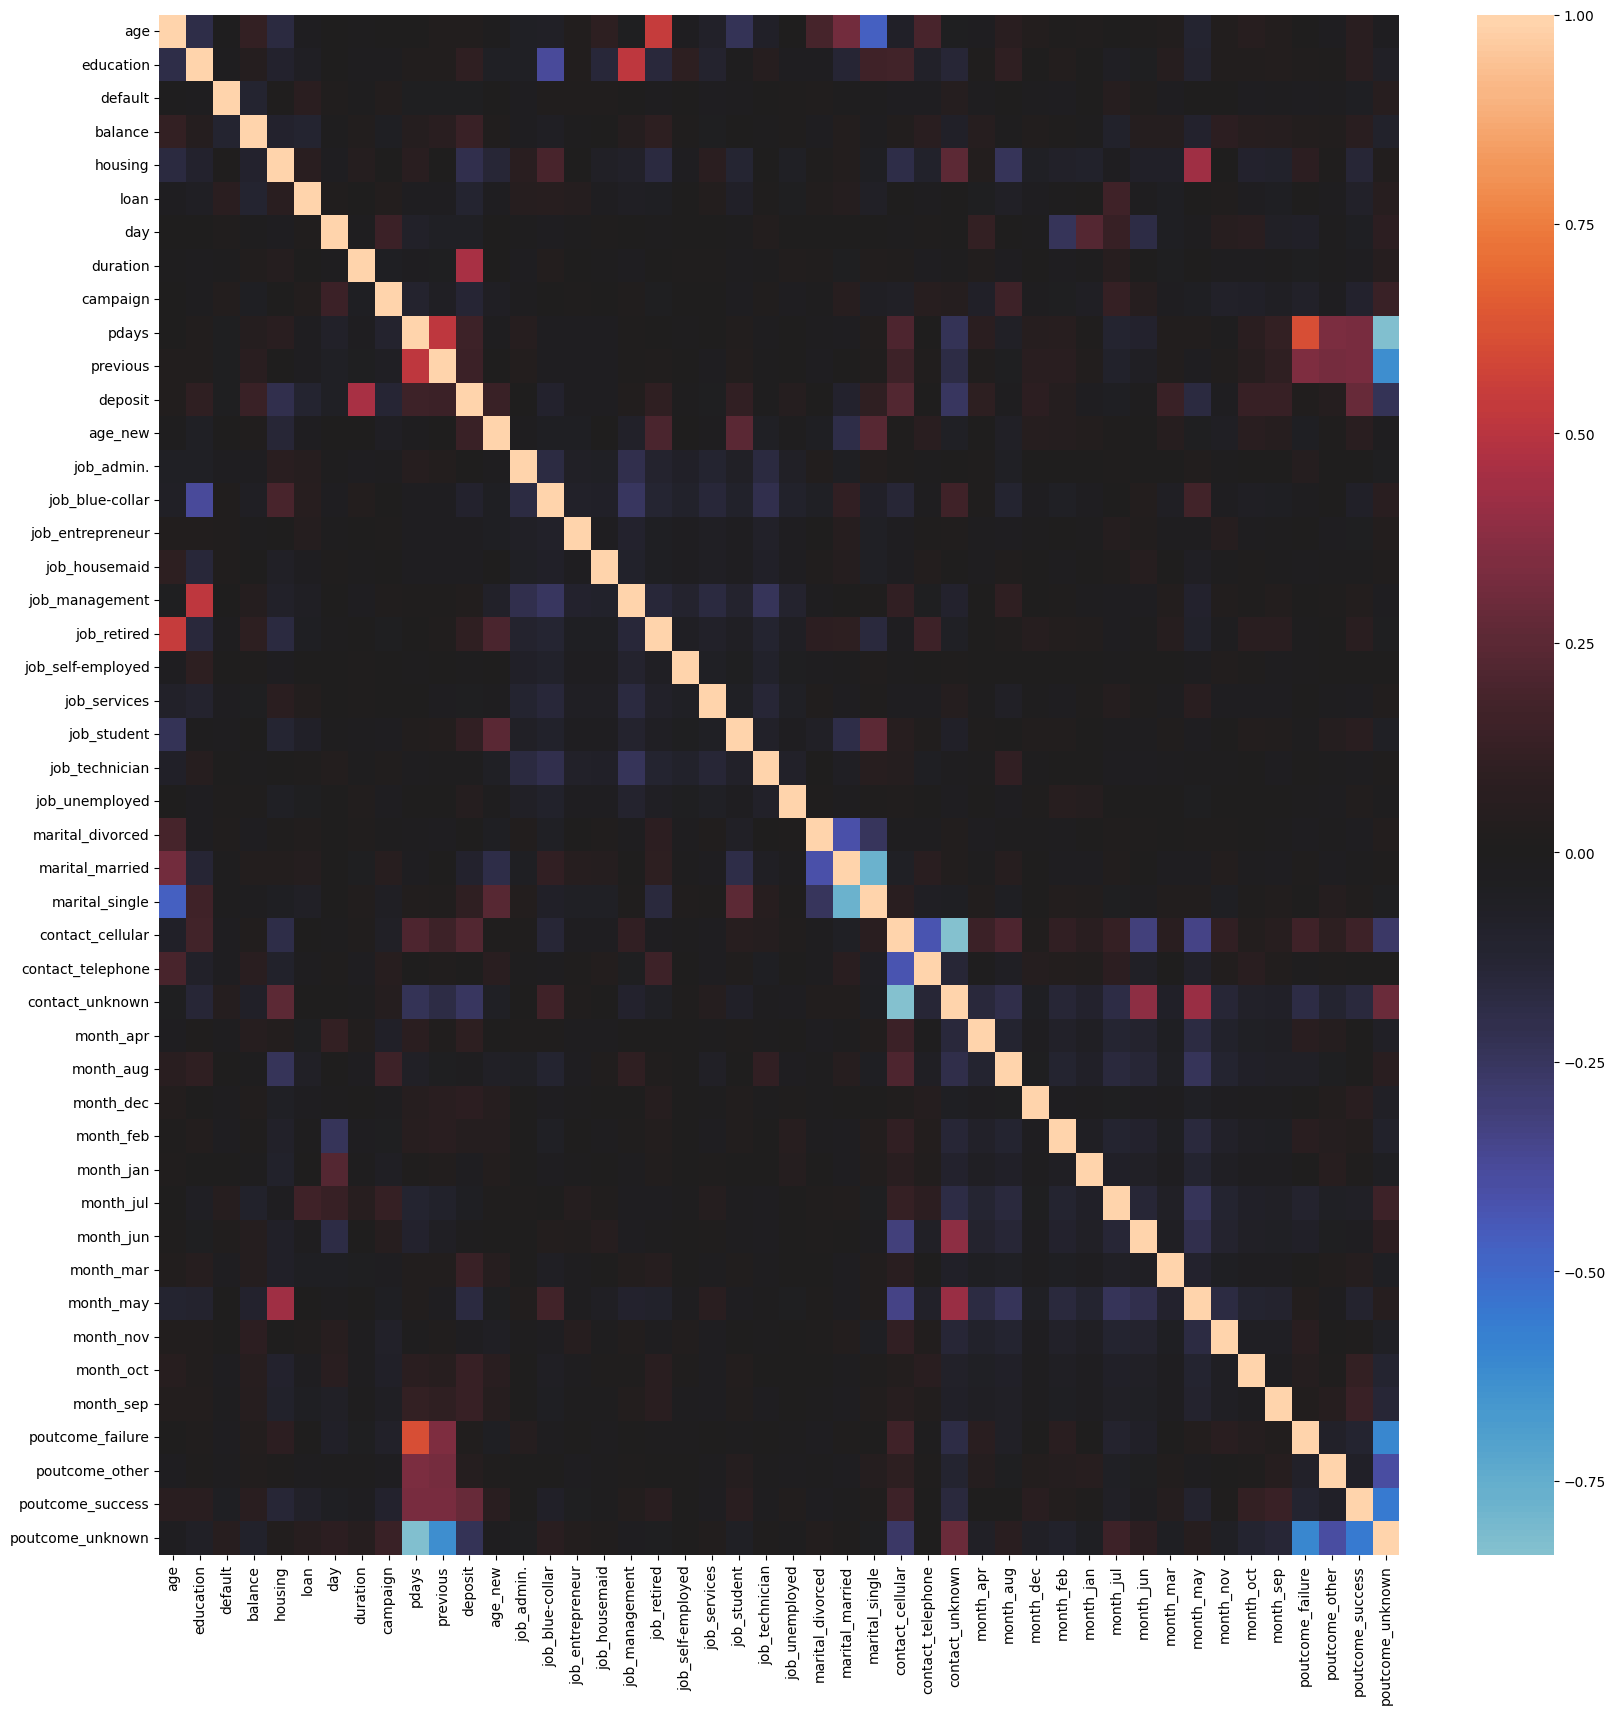

In [50]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
# Корреляция всех признаков

fig = plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), center=0);

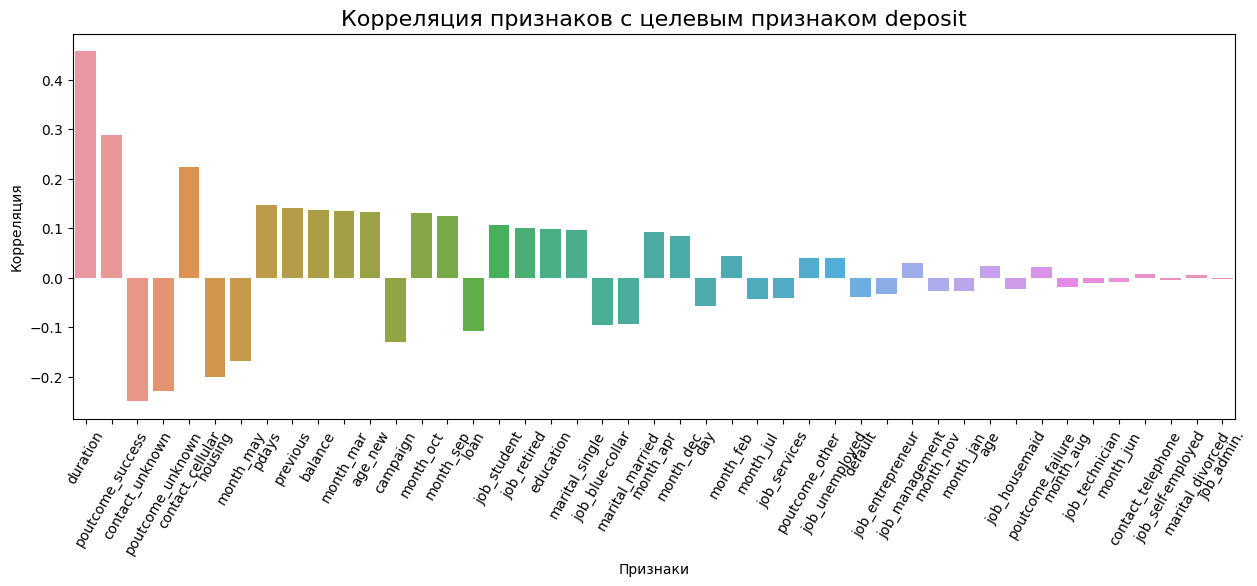

In [32]:
# Корреляция с целевым признаком

fig = plt.figure(figsize=(15,5))
plot_cor = df_corr.drop('deposit')
feature_cor = abs(plot_cor['deposit']).sort_values(ascending=False).index
ax = sns.barplot(
    data=plot_cor.reset_index(), x='index', y='deposit',
    order = feature_cor)
plt.xticks(rotation=60)
ax.set(xlabel='Признаки', ylabel='Корреляция')
ax.set_title('Корреляция признаков с целевым признаком deposit', fontsize=16);

In [33]:
# Проверяем, есть ли среди признаков мультиколлинеарность (достаточно сильная корреляция не менее 0.9.)
df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

# Среди признаков НЕТ мультиколлинеарности

[]

### Задания 7 и 8 Определение целевой переменной и предикторов, разделение выборки на обучающую и тестовую

In [56]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [35]:
# рассчитайте необходимые показатели

print('Размер тестовой выборки: {}'.format(X_test.shape))

Размер тестовой выборки: (3335, 45)


In [36]:
# Каково среднее значение целевой переменной на тестовой выборке

round(y_test.mean(), 2)

0.46

### Задание 9 Отбор признаков

In [57]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)

selected_cols = selector.get_feature_names_out()

print(f'Выбранные признаки: {selected_cols}')
X_train = selector.transform(X_train)
X_test =selector.transform(X_test)

Выбранные признаки: ['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_new'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10 Нормализация данных

In [58]:
# нормализуйте данные с помощью minmaxsxaler

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
# Среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки

X_test_mean = round(np.mean(X_test[:,0]), 2)
X_test_mean

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1 Логистическая регрессия

In [40]:
# обучите логистическую регрессию и рассчитайте метрики качества

log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)

# Обучаем
log_reg.fit(X_train, y_train)

#Делаем предсказание класса
y_pred = log_reg.predict(X_test)

#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy: 0.81


### Задания 2 Дерево решений

In [59]:
# обучите решающие деревья, настройте максимальную глубину

#Создаём объект класса DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt.fit(X_train, y_train)

#Делаем предсказание класса
y_pred = dt.predict(X_test)

#Делаем предсказание класса
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

print('Обучающая выборка:\n{}'.format(metrics.classification_report(y_train, y_pred_train)))
print('Тестовая выборка:\n{}'.format(metrics.classification_report(y_test, y_pred_test)))

Обучающая выборка:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 3 Дерево решений<br>
Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

Максимальная точность на тесте: 0.81
Оптимальная глубина дерева: 6


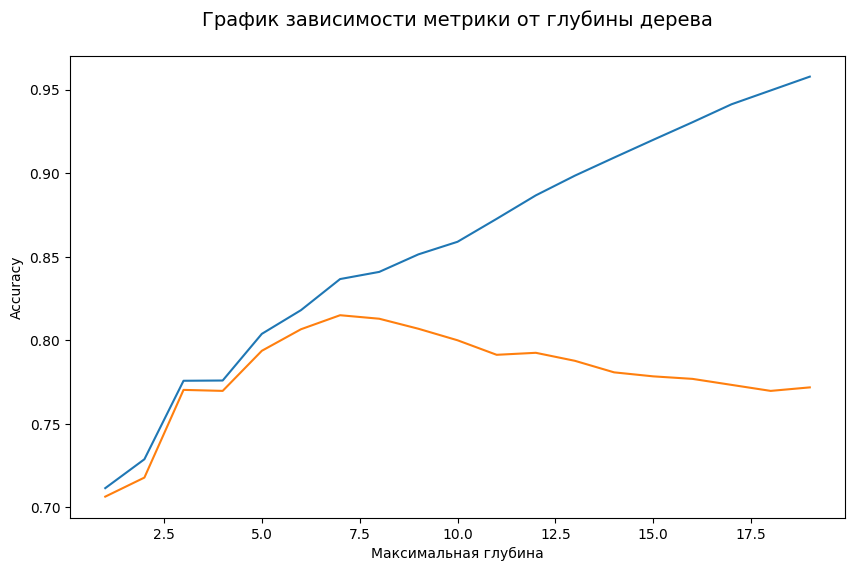

In [65]:
train_scores = []
test_scores = []
for max_depth in range(1,20):
    dt = tree.DecisionTreeClassifier(
        criterion='entropy', random_state=42, max_depth=max_depth)
    dt.fit(X_train, y_train)
    y_pred_train = dt.predict(X_train)
    y_pred_test = dt.predict(X_test)
    train_scores.append(metrics.accuracy_score(y_train, y_pred_train))
    test_scores.append(metrics.accuracy_score(y_test, y_pred_test))
    
# Рисуем график
max_depth = list(range(1,20))
fig = plt.figure(figsize=(10, 6))
ax = sns.lineplot(x=max_depth, y=train_scores)
sns.lineplot(x=max_depth, y=test_scores)
ax.set(xlabel='Максимальная глубина', ylabel='Accuracy')
ax.set_title('График зависимости метрики от глубины дерева\n', fontsize=14);

# Поиск оптимального параметра
print(f'Максимальная точность на тесте: {np.amax(test_scores):.2f}')
print(f'Оптимальная глубина дерева: {np.argmax(test_scores)}')

### Задание 5 Подбор гиперпараметров Gridsearch

In [71]:
# подберите оптимальные параметры с помощью gridsearch

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7],
              }

grid_search = GridSearchCV(
        estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42), 
    param_grid=param_grid
) 

%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_pred_test = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 1.91 s
Wall time: 2.81 s
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1 Случайный лес

In [72]:
# обучите на ваших данных случайный лес

rf = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, 
    max_depth=10, random_state=42)

rf.fit(X_train, y_train)

y_pred_test = rf.predict(X_test)

print('Тестовая выборка:\n{}'.format(metrics.classification_report(y_test, y_pred_test)))

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3 Градиентный спуск

In [73]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5,
    max_depth=5, random_state=42)
gb.fit(X_train, y_train)

y_pred_test = gb.predict(X_test)

print('Тестовая выборка:\n{}'.format(metrics.classification_report(y_test, y_pred_test)))

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4 Ансамблирование. Стекинг

In [74]:
# объедините уже известные вам алгоритмы с помощью стекинга

dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=7, random_state=42)
log_reg = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
gb = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)

estimators = [('dtree', dt), ('logreg', log_reg), ('gridboost', gb)]

classif = ensemble.StackingClassifier(estimators=estimators)

classif.fit(X_train, y_train)

y_pred_test = classif.predict(X_test)

print('Тестовая выборка:\n{}'.format(metrics.classification_report(y_test, y_pred_test)))

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5 Наиболее важные признаки

In [83]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

gb = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5,
    max_depth=5, random_state=42)

gb.fit(X_train, y_train)

sorted(list(zip(selected_cols, gb.feature_importances_)), key=lambda x: x[1], reverse=True)


[('duration', 0.5071058721451659),
 ('poutcome_success', 0.11495825455712295),
 ('contact_unknown', 0.07258212753674755),
 ('balance', 0.05795212468091972),
 ('pdays', 0.05508257844117282),
 ('housing', 0.047725379385995796),
 ('age_new', 0.03990225428089568),
 ('month_mar', 0.027818612298223928),
 ('month_oct', 0.019880155415052104),
 ('month_may', 0.01524455070689359),
 ('campaign', 0.014776926675192212),
 ('month_sep', 0.013529992756931104),
 ('previous', 0.008438741473457433),
 ('contact_cellular', 0.003620125904267944),
 ('poutcome_unknown', 0.001382303741961252)]

### Задания 6,7,8 Подбор гиперпараметров Optuna

In [87]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
    # пространство гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42)
    
    # обучаем модель
    model.fit(X_train, y_train)
    
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score


# Поиск оптимальных гиперпараметров
#sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_rf, n_trials=20)
print(f'Лучшие параметры:\n{study.best_params}')

[I 2023-07-16 12:27:29,255] A new study created in memory with name: RandomForestClassifier
[I 2023-07-16 12:27:31,608] Trial 0 finished with value: 0.8480200344341837 and parameters: {'n_estimators': 119, 'max_depth': 14, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8480200344341837.
[I 2023-07-16 12:27:33,928] Trial 1 finished with value: 0.8614759224515323 and parameters: {'n_estimators': 151, 'max_depth': 19, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8614759224515323.
[I 2023-07-16 12:27:37,514] Trial 2 finished with value: 0.9248663942156555 and parameters: {'n_estimators': 159, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9248663942156555.
[I 2023-07-16 12:27:41,328] Trial 3 finished with value: 0.8670012547051442 and parameters: {'n_estimators': 191, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9248663942156555.
[I 2023-07-16 12:27:43,306] Trial 4 finished with value: 0.8515037593984962 and parameters: {'n_

Лучшие параметры:
{'n_estimators': 173, 'max_depth': 28, 'min_samples_leaf': 2}


In [88]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
print('Тестовая выборка:\n{}'.format(metrics.classification_report(y_test, y_pred_test)))

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



**ВЫВОДЫ по проделанной работе:**<br>

* Была проведена предобработка данных, найдены и заполнены пропуски, найдены и удалены выбросы.
* Проведен разведывательный анализ данных, кодирование данных, нормализация признаков, отбор признаков.
* Простые базовые модели (логистическая регрессия и дерево решений) показали метрики accuracy 0,81 и 0,82 (f1 0.8) соответственно, подбор параметров по факту не улучшил метрику (accuracy 0,81, f1 0.8).
* Ансамблевые модели - случайный лес, градиентный бустинг на решающих деревьх показали лучшие метрики (accuracy 0,83 и f1 0.82). Стекинг лишь немного улучшил метрики по сравнению с простыми решениями (accuracy 0,82 и f1 0.81).
* Подбор параметров с помощью метода Optuna так же не улучшил метрики.

**Что можно улучшить:**
Можно попробовать улучшить качество предсказания, используя более продвинутые подходы для удаления выбросов или беря больше признаков. Так же можно создать бόльшую сетку параметров для отбора оптимизацией или использовать новые алгоритмы.